# Introduction

The following uses sklearn's Decision Tree to fit a classifier that distinguishes between a pair of sketch categories from the Quick, Draw! dataset from Google:

https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap/?pli=1

Categories were chosen below to make a somewhat difficult comparison (two objects that typically look alike)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import copy
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_validate
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
import graphviz

from utilities import computeLearningCurve, plotScoreCurve, plotTimeCurve, plotIterationCurve, plotConfusionMatrix, getDrawData, drawIncorrectSketches, heatmap

# Settings

In [3]:
# Random seed used for all "random" generators
randomSeed = 1

# Number of parallel jobs used for some sklearn routines (-1 means use all cpus)
njobs = -1

# Fractional size of test dataset
testSize = 1/5.

# Number of folds for GridSearchCV
nfolds = 5

# Settings to control which features are used
pRows = 28
pCols = 28
pColNames = list(range(pRows * pCols))
pScale = 255.0 # Scale factor for pixels.  Pixel raw data is 0 to 255.  Set to 1 to avoid scaling

# Number of samples PER CATEGORY (defined below)
nSamples = 7500

# Names of all models to include
# names = ['baseball', 'basketball', 'camel', 'cow', 'clock', 'wristwatch']
names = ['baseball', 'basketball']

# Plot min/max extents for all accuracy plots
accuracyMin = 0.6
accuracyMax = 1.0

# Folds (denoted by number of data points used) for learning curve
learningCurveFolds = np.concatenate([np.geomspace(10, 1000, 5).round(), np.array([2000, 4000, 6000, 9000])]).astype('int')

In [4]:
# Used for plot names
est = "quickdraw_dt"
scoreText = "Score (Classification Accuracy)"

# Load Data

In [5]:
dataDict = getDrawData(names, nSamples=nSamples)
data = dataDict['df']
nameDict = dataDict['nameDict']

print("")
print("Loaded the following named categories, with classNumbers shown")
print(nameDict)

# Scale pixel data
for col in pColNames:
    data[col] = data[col] / pScale

Loading 7500 samples for baseball from ./data/full_numpy_bitmap_baseball.npy
Loading 7500 samples for basketball from ./data/full_numpy_bitmap_basketball.npy

Loaded the following named categories, with classNumbers shown
{'baseball': 0, 'basketball': 1}


In [6]:
# Create X, y, XTest, yTest using just the features we care about...

XFull = data.loc[:, pColNames].values
print(f'XFull.shape = {XFull.shape}')
yFull = data.loc[:, 'classNumber'].values
print(f'yFull.shape = {yFull.shape}')

X, XTest, y, yTest = train_test_split(XFull, yFull, test_size=testSize, 
                                      random_state=randomSeed, stratify=yFull)

print('')
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')
print(f'Ratio of y=1 to y=0 for Training data: {(y == 1).sum() / float(len(y))} (should be 0.5)')

print('')
print(f'XTest.shape = {XTest.shape}')
print(f'yTest.shape = {yTest.shape}')
print(f'Ratio of yTest=1 to yTest=0 for Test data: {(yTest == 1).sum() / float(len(yTest))} (should be 0.5)')

XFull.shape = (15000, 784)
yFull.shape = (15000,)

X.shape = (12000, 784)
y.shape = (12000,)
Ratio of y=1 to y=0 for Training data: 0.5 (should be 0.5)

XTest.shape = (3000, 784)
yTest.shape = (3000,)
Ratio of yTest=1 to yTest=0 for Test data: 0.5 (should be 0.5)


# Initial Parameter Setting using GridSearchCV with Nominal Data Set

Examine the hyperparameter space using GridSearchCV.

In [7]:
paramGrid = {
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 30, 40, 50] + list(range(75, 401, 25))
}

nData = 2000
XSubset = X[:nData]
ySubset = y[:nData]

gs = GridSearchCV(DecisionTreeClassifier(criterion='entropy', random_state=randomSeed), param_grid=paramGrid, cv=nfolds, n_jobs=njobs, 
                      verbose=10, return_train_score=True)

In [8]:
# fit!
print(f"Fitting model using {XSubset.shape[0]} data samples")
gs.fit(XSubset, ySubset)

pltNameSuffix = '_' + '_initial'
with open(est + pltNameSuffix + "_gs.pkl", 'wb') as fout:
    pickle.dump(gs, file=fout)

Fitting model using 2000 data samples
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 118 out of 120 | elapsed:   33.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   33.4s finished


In [9]:
gs_results_df = pd.DataFrame(gs.cv_results_)
gs_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.504444,0.020700,0.001197,3.988748e-04,2,{'min_samples_split': 2},0.703242,0.7075,0.6950,0.6875,...,0.6880,0.021775,17,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,2.534856,0.880227,0.006582,5.592595e-03,3,{'min_samples_split': 3},0.703242,0.7050,0.6950,0.6875,...,0.6875,0.021346,18,1.000000,0.999375,1.000000,1.000000,1.000000,0.999875,0.000250
2,2.517469,0.892738,0.004588,2.792958e-03,4,{'min_samples_split': 4},0.708229,0.6625,0.6750,0.6975,...,0.6745,0.027829,24,0.997498,0.998750,0.999375,0.998750,0.998126,0.998500,0.000638
3,2.083430,0.381065,0.009574,1.267240e-02,5,{'min_samples_split': 5},0.685786,0.6950,0.7000,0.6975,...,0.6815,0.026611,19,0.996873,0.995000,0.998125,0.995000,0.998126,0.996625,0.001403
4,2.214081,0.066756,0.002991,1.577171e-06,10,{'min_samples_split': 10},0.685786,0.6900,0.6900,0.7050,...,0.6780,0.030148,23,0.978737,0.972500,0.976875,0.980625,0.974391,0.976626,0.002916
5,1.278781,0.372973,0.002992,3.568323e-07,15,{'min_samples_split': 15},0.705736,0.7025,0.7000,0.6950,...,0.6910,0.019966,15,0.966229,0.944375,0.950625,0.951875,0.950656,0.952752,0.007232
6,1.135962,0.079477,0.011370,1.275037e-02,20,{'min_samples_split': 20},0.705736,0.7000,0.6975,0.6800,...,0.6815,0.029935,19,0.943089,0.929375,0.926250,0.943125,0.926921,0.933752,0.007709
7,1.259832,0.153971,0.002992,3.814697e-07,30,{'min_samples_split': 30},0.685786,0.7175,0.7000,0.6875,...,0.6815,0.034356,19,0.902439,0.889375,0.888125,0.898750,0.893192,0.894376,0.005470
8,1.191216,0.121365,0.002993,8.930838e-04,40,{'min_samples_split': 40},0.685786,0.6950,0.6850,0.6950,...,0.6785,0.023816,22,0.883677,0.868750,0.870000,0.874375,0.858838,0.871128,0.008075
9,1.321068,0.139874,0.002992,4.523674e-07,50,{'min_samples_split': 50},0.695761,0.7150,0.7175,0.6900,...,0.6905,0.030106,16,0.856160,0.860000,0.842500,0.855000,0.841349,0.851002,0.007603


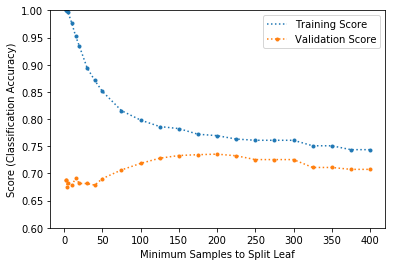

In [10]:
fig, ax = plt.subplots()

gs_results_df.plot(x='param_min_samples_split', y='mean_train_score', label='Training Score', ax=ax, marker='.', ls=":")
gs_results_df.plot(x='param_min_samples_split', y='mean_test_score', label='Validation Score', ax=ax, marker='.', ls=":")
gs_results_df.to_csv(est + pltNameSuffix + "gs_results.csv")

ax.set_xlabel("Minimum Samples to Split Leaf")
ax.set_ylabel(scoreText)
ax.set_ylim(bottom=accuracyMin, top=accuracyMax)

fig.savefig(est + pltNameSuffix + "_gs")

In [11]:
print(f'From this, we choose the following parameters for computing the learning curve:\n{gs.best_params_}')
score = gs.score(XTest, yTest)
print(f'This model has score of {gs.best_score_} in cross validation for grid search and {score} on the held-out test data')

From this, we choose the following parameters for computing the learning curve:
{'min_samples_split': 200}
This model has score of 0.7355 in cross validation for grid search and 0.712 on the held-out test data


We see that for a training set of 2000 samples, we obtain fairly significant gains in training score as we introduce pruning (via minimum number of samples required to split a leaf).  The best result comes from a significant pruning.  This can be visualized in the figures output below.

In [12]:
dt_full = copy.deepcopy(gs.best_estimator_)
dt_full.min_samples_split = 2 # Reset back to default
dt_full.fit(XSubset, ySubset) # Remake full tree
print(f'The full tree has {dt_full.tree_.node_count} nodes')

vis = tree.export_graphviz(dt_full, out_file=None, filled=True, proportion=False)
graph = graphviz.Source(vis)
graph.render(est + pltNameSuffix + "_full")

dt_pruned = gs.best_estimator_
print(f'The pruned tree has {dt_pruned.tree_.node_count} nodes')

vis = tree.export_graphviz(dt_pruned, out_file=None, filled=True, proportion=False)
graph = graphviz.Source(vis)
graph.render(est + pltNameSuffix + "_pruned")

The full tree has 309 nodes
The pruned tree has 33 nodes


'quickdraw_dt__initial_pruned.pdf'

# Learning Curves

Produce learning curves (train/test accuracy vs number of examples and train/score time vs number of examples) using the above chosen parameters to determine:

* Whether the classifier is bias or variance limited
* Limit to which more data points will not be helpful

NOTE: UndefinedMetricWarnings may occur below in some cases with small data due to poor classification

In [13]:
lc_params = copy.deepcopy(gs.best_params_)

lcNameBase = est + "_" + "_lc_" + str(len(learningCurveFolds)) + "f_" + str(X.shape[0]) + "ex"
lcName = lcNameBase  + ".pkl"

print(f"Computing learning curves with params: \n{lc_params}")
print(f"Over {len(learningCurveFolds)} folds: {learningCurveFolds}")
# Note that computeLearningCurve with testSize specified splits X, y into a test and validation set 
# before training (validation set is used for validation curve)
lc = computeLearningCurve(DecisionTreeClassifier(criterion='entropy', random_state=randomSeed, **lc_params), X, y, testSize = testSize,
                          learningCurveFolds=learningCurveFolds, stratifyLearningCurveFolds=True, 
                         randomSeed=randomSeed, saveas=lcName, returnEstimators=True)

Computing learning curves with params: 
{'min_samples_split': 200}
Over 9 folds: [  10   32  100  316 1000 2000 4000 6000 9000]
Indices included at fold 0: 10
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.01s
	Total time for this iteration = 0.01s
Indices included at fold 1: 32
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.01s
	Total time for this iteration = 0.01s
Indices included at fold 2: 100
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.01s
	Total time for this iteration = 0.02s
Indices included at fold 3: 316
	Model trained in 0.02s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.01s
	Total time for this iteration = 0.04s
Indices included at fold 4: 1000
	Model trained in 0.33s
	Model Scored on Training Data in 0.01s
	Model Scored on Test Data in 0.01s
	Total time for this iteration = 0.36s
Indices included a

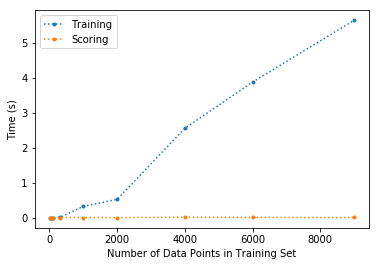

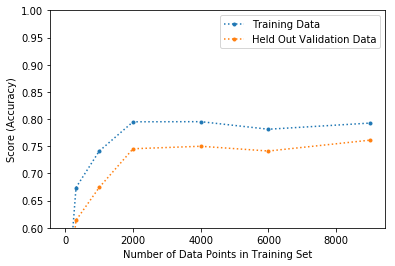

In [14]:
plotTimeCurve(lc, savefig = lcNameBase + "_time")
# plt.legend()
plt.show()

plotScoreCurve(lc, bottom=accuracyMin, top=accuracyMax, savefig = lcNameBase + "_score")
# plt.legend()
plt.show()

In [15]:
iBest = np.argmax(lc['test_score'])
bestScore = lc['test_score'][iBest]
bestData = lc['n_data'][iBest]
print(f'Best validation score of {bestScore:.3} achieved with {bestData:d} samples')

Best validation score of 0.761 achieved with 9000 samples


Learning curves show that additional training data did improve the classifier, although improvements leveled off around 2000 samples.  The gap between training and validation error is fairly small, indicating only additional data likely wont improve the classifier by more than a few percent.  

# Refit Model on Best Data

Refit the model using a second GridSearchCV search for hyperparameters, then score the model on the held out test data. 

In [16]:
paramGrid = {
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 30, 40, 50] + list(range(75, 401, 25))
}

nData = bestData
XSubset = X[:nData]
ySubset = y[:nData]

gs = GridSearchCV(DecisionTreeClassifier(criterion='entropy', random_state=randomSeed), param_grid=paramGrid, cv=nfolds, n_jobs=njobs, 
                      verbose=10, return_train_score=True)

In [17]:
# fit!
print(f"Fitting model using {XSubset.shape[0]} data samples")
gs.fit(XSubset, ySubset)
pltNameSuffix = '_final'
with open(est + pltNameSuffix + "_gs.pkl", 'wb') as fout:
    pickle.dump(gs, file=fout)

Fitting model using 9000 data samples
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 118 out of 120 | elapsed:  1.7min remaining:    1.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.7min finished


In [18]:
gs_results_df = pd.DataFrame(gs.cv_results_)
gs_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,7.166440,0.249521,0.018550,0.010697,2,{'min_samples_split': 2},0.710716,0.700167,0.687778,0.723735,...,0.704444,0.012072,21,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,8.238174,0.693832,0.019149,0.012747,3,{'min_samples_split': 3},0.711272,0.705719,0.686667,0.725403,...,0.705778,0.012773,19,0.999861,0.999861,0.999861,0.999722,1.000000,0.999861,0.000088
2,8.250342,0.717611,0.015359,0.004487,4,{'min_samples_split': 4},0.710716,0.702943,0.702778,0.727626,...,0.708444,0.010401,18,0.999305,0.998611,0.998472,0.999167,0.999306,0.998972,0.000358
3,9.021281,1.174638,0.013763,0.001466,5,{'min_samples_split': 5},0.705719,0.695169,0.697222,0.721512,...,0.701778,0.011185,23,0.997500,0.996249,0.996806,0.998195,0.996806,0.997111,0.000671
4,7.841834,0.233957,0.014561,0.006693,10,{'min_samples_split': 10},0.691838,0.696280,0.682222,0.723735,...,0.697111,0.014072,24,0.981247,0.978886,0.977361,0.979725,0.979308,0.979306,0.001257
5,7.427142,0.433263,0.011370,0.000488,15,{'min_samples_split': 15},0.706830,0.706274,0.683333,0.728182,...,0.702778,0.015710,22,0.958883,0.958883,0.957917,0.959728,0.955145,0.958111,0.001590
6,6.381139,0.564666,0.012767,0.003116,20,{'min_samples_split': 20},0.710716,0.705164,0.704444,0.717065,...,0.705000,0.009808,20,0.940131,0.939575,0.937222,0.941953,0.933065,0.938389,0.003061
7,5.798696,0.253346,0.014561,0.005069,30,{'min_samples_split': 30},0.720155,0.705164,0.711667,0.730406,...,0.714111,0.010076,17,0.904431,0.904153,0.899583,0.909457,0.904041,0.904333,0.003129
8,5.621371,0.174757,0.011170,0.000399,40,{'min_samples_split': 40},0.721266,0.722932,0.707222,0.743191,...,0.720889,0.012730,16,0.877622,0.882067,0.874306,0.881822,0.880017,0.879167,0.002905
9,5.578285,0.158080,0.010572,0.000798,50,{'min_samples_split': 50},0.729039,0.726263,0.720556,0.746526,...,0.729222,0.009091,15,0.859425,0.862759,0.860000,0.867102,0.866546,0.863166,0.003197


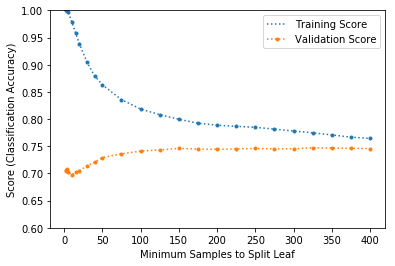

In [19]:
fig, ax = plt.subplots()

gs_results_df.plot(x='param_min_samples_split', y='mean_train_score', label='Training Score', ax=ax, marker='.', ls=":")
gs_results_df.plot(x='param_min_samples_split', y='mean_test_score', label='Validation Score', ax=ax, marker='.', ls=":")
gs_results_df.to_csv(est + pltNameSuffix + "gs_results.csv")

ax.set_xlabel("Minimum Samples to Split Leaf")
ax.set_ylabel(scoreText)
ax.set_ylim(bottom=accuracyMin, top=accuracyMax)

fig.savefig(est + pltNameSuffix + "_gs")

In [20]:
print(f'From this, we choose the following parameters for computing the learning curve:\n{gs.best_params_}')
score = gs.score(XTest, yTest)
print(f'This model has score of {gs.best_score_} in cross validation for grid search and {score} on the held-out test data')

From this, we choose the following parameters for computing the learning curve:
{'min_samples_split': 325}
This model has score of 0.7472222222222222 in cross validation for grid search and 0.742 on the held-out test data


This shows similar results to those above, except that with the additional data more agressive pruning yields slightly better results. 

# Confusion Matrix

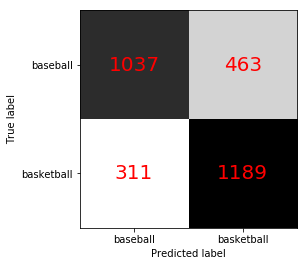

In [21]:
predictions = gs.predict(XTest)
ax = plotConfusionMatrix(yTest, predictions, names, savefig=est + pltNameSuffix + "_confusion")

# Examples of Incorrect Classifications

Although classification performance was ok, it is insightful to see what we misclassified...

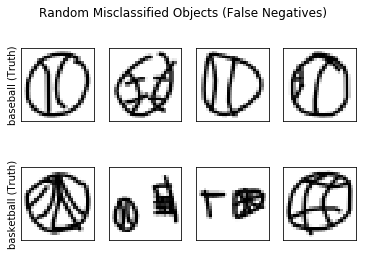

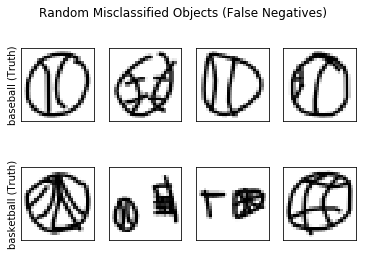

In [22]:
classNumbers = [nameDict[name] for name in names]
drawIncorrectSketches(XTest, yTest, predictions, classNumbers=[0, 1], names=names, n=4, randomSeed=randomSeed, savefig=est + pltNameSuffix + "_Misclassified")

In this case, some images seem pretty hard to tell which they are!